# **AIRLINES PERFORMANCE**

## **Lead Question**

How does the COVID-19 impacted Airlines ON TIME performance? A comparision of 2019 against 2020 and early 2021 data.



## **To run this notebook you need...**

In [ ]:
 # !jupyter notebook --NotebookApp.max_buffer_size=12884895291   JUST RUN THIS IF IT'S A LOCAL JUPYTER NB

In [ ]:
!pip  install 'fsspec>=0.3.3' 

     |████████████████████████████████| 112kB 7.2MB/s 


In [ ]:
!!pip install "dask[dataframe]"

['Requirement already satisfied: dask[dataframe] in /usr/local/lib/python3.7/dist-packages (2.12.0)',
 'Requirement already satisfied: numpy>=1.13.0; extra == "dataframe" in /usr/local/lib/python3.7/dist-packages (from dask[dataframe]) (1.19.5)',
 'Requirement already satisfied: toolz>=0.7.3; extra == "dataframe" in /usr/local/lib/python3.7/dist-packages (from dask[dataframe]) (0.11.1)',
 'Requirement already satisfied: fsspec>=0.6.0; extra == "dataframe" in /usr/local/lib/python3.7/dist-packages (from dask[dataframe]) (2021.5.0)',
 'Collecting partd>=0.3.10; extra == "dataframe"',
 '  Downloading https://files.pythonhosted.org/packages/41/94/360258a68b55f47859d72b2d0b2b3cfe0ca4fbbcb81b78812bd00ae86b7c/partd-1.2.0-py3-none-any.whl',
 'Requirement already satisfied: pandas>=0.23.0; extra == "dataframe" in /usr/local/lib/python3.7/dist-packages (from dask[dataframe]) (1.1.5)',
 'Collecting locket',
 '  Downloading https://files.pythonhosted.org/packages/50/b8/e789e45b9b9c2db75e9d9e6ceb02

## **Related Resources**

[IBM 1987-November 2020 Dataset](https://developer.ibm.com/exchanges/data/all/airline/) I filtered it to get the 2018-2029 dataset.

[IBM Starter Code](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/0b82dbf1-7600-4780-b867-0ecb47834033/)

[Information about columns](https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/data-preview/index.html?_ga=2.115894159.882891383.1621395276-1071326701.1621279873)  

[Data original Source](https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr&V0s1_b0yB=D) -  I built the 2020-2021 dataset with this source.

[Dictionaries related to the columns](https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr)

* [Reporting Airline Name (Unique Carrier Code)](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_haVdhR_PNeeVRef)

* [DOT ID Reporting Airline](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_NVeYVaR_VQ)

* [Origin/Destination Airport Name](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_NVecbeg_VQ)

* [Origin/Destination City Market](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_PVgl_ZNeXRg_VQ)

* And Others

[Geo Json Airports](https://data.opendatasoft.com/explore/dataset/osm-world-airports@babel/export/)

## **THE PROJECT**

The Data Geologation:  USA

### **Preparing the Dataset**
The 1987-2020 data came from IBM, but they sourced from the United States Bureau of Transportation Statistics, which I used to get 2020 - March 2021 Data. I used those 2 sources to build a dataset containing the Airlines ON TIME Performance Data from 2019 to March 2021 

> IBM dataset had up to March 2020, but for my analysis of the impact of COVID-19 in Airline On Time Performance I needed 2019, 2020 and up to the most recent data available by May 2021 when I started the analysis, the most recent data was from March 2021. The analysis was done in May 2021. Why those years? 2018 year to understand PRE-COVID Perfomance and the COVID-19 time period to understand the pandemic impacts. So I first readed the IBM's 80GB dataset to understand what columns I needed to download from the **US Bureau of Transportation Statistics**, *the source IBM used for its dataset*, to build the complete dataset with data from 2019 to 2021(March). I could've wrote a python script to download the 2020-2021 data, but it was just 15 csv to download. I encourage someone analysing future years of 'Airline On-Time Perfomance Data' to write a script that does so.

**Load Google Drive**

All the necessary data sets should be there and the created ones will be stored there too.

In [ ]:
from google.colab import drive
# You'll be asked for a code, select the account storing the data sets and notebook
drive.mount('/content/drive',  force_remount=True)  

# Use next line if you mounted the wrong drive
# drive.flush_and_unmount()

Mounted at /content/drive


**Tools to work with the big file**

In [ ]:
import dask.dataframe as dd
from distributed import LocalCluster, Client
from dask.diagnostics import ProgressBar

# CLIENT CODE WHEN RUNNING DASK ON A LOCAL COMPUTER
# client = Client(LocalCluster(n_workers=1, threads_per_worker=4, processes=False, memory_limit='10GB'))
# client

In [ ]:
# This dictionary helps to decrease load time, as dask doesn't have to guess
# the data type. Also, it saves memory by avoiding big data types
# when not necessary. It was created after understanding the dataset. 
# Still a further correction of data type will be needed
typesDict = {'Year':'int','Quarter':'int','Month':'int','DayofMonth':'int','DayOfWeek':'int',
           'FlightDate':'object','Reporting_Airline':'object','DOT_ID_Reporting_Airline':'int',
           'IATA_CODE_Reporting_Airline':'object','Tail_Number':'object','Flight_Number_Reporting_Airline':'int',
           'OriginAirportID':'int','OriginAirportSeqID':'int','OriginCityMarketID':'int',
           'Origin':'object','OriginCityName':'object',
           'OriginState':'object','OriginStateFips':'int32','OriginStateName':'object',
           'OriginWac':'int','DestAirportID':'int',
           'DestAirportSeqID':'int','DestCityMarketID':'int','Dest':'object',
           'DestCityName':'object','DestState':'object','DestStateFips':'int32',
           'DestStateName':'object','DestWac':'int','CRSDepTime':'int32','DepTime':'int64',
           'DepDelay':'float32','DepDelayMinutes':'float32','DepDel15':'float32',
           'DepartureDelayGroups':'int32','DepTimeBlk':'object','TaxiOut':'float32',
           'WheelsOff':'int32','WheelsOn':'int32','TaxiIn':'float32','CRSArrTime':'int32',
           'ArrTime':'int64','ArrDelay':'float32','ArrDelayMinutes':'float32','ArrDel15':'float32',
           'ArrivalDelayGroups':'float32','ArrTimeBlk':'object','Cancelled':'float32',
           'CancellationCode':'object','Diverted':'float32','CRSElapsedTime':'float32',
           'ActualElapsedTime':'float32','AirTime':'float32','Flights':'float32','Distance':'float32',
           'DistanceGroup':'int64','CarrierDelay':'float32','WeatherDelay':'float32',
           'NASDelay':'float32','SecurityDelay':'float32','LateAircraftDelay':'float32',
           'FirstDepTime':'float32','TotalAddGTime':'float32','LongestAddGTime':'float32',
           'DivAirportLandings':'float32','DivReachedDest':'float32',
           'DivActualElapsedTime':'float32','DivArrDelay':'float32',
           'DivDistance':'float32','Div1Airport':'object','Div1AirportID':'float32','Div1AirportSeqID':'float32',
           'Div1WheelsOn':'float32','Div1TotalGTime':'float32','Div1LongestGTime':'float32',
           'Div1WheelsOff':'float32','Div1TailNum':'object','Div2Airport':'object',
           'Div2AirportID':'float32','Div2AirportSeqID':'float32','Div2WheelsOn':'float32',
           'Div2TotalGTime':'float64','Div2LongestGTime':'float32','Div2WheelsOff':'float32',
           'Div2TailNum':'object','Div3Airport':'float32','Div3AirportID':'float32',
           'Div3AirportSeqID':'float32','Div3WheelsOn':'float32','Div3TotalGTime':'float32',
           'Div3LongestGTime':'float32','Div3WheelsOff':'float32','Div3TailNum':'float32',
           'Div4Airport':'float32','Div4AirportID':'float32','Div4AirportSeqID':'float32',
           'Div4WheelsOn':'float32','Div4TotalGTime':'float32','Div4LongestGTime':'float32',
           'Div4WheelsOff':'float32','Div4TailNum':'float32','Div5Airport':'float32',
           'Div5AirportID':'float32','Div5AirportSeqID':'float32','Div5WheelsOn':'float32',
           'Div5TotalGTime':'float32','Div5LongestGTime':'float32','Div5WheelsOff':'float32',
           'Div5TailNum':'float32'}

In [ ]:
# Path in GDrive to fin the IBM Dataset
path = '/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/IBM_1987_2020_80GB.csv' 

# The Data set needs to use and encoding.
ibmDf = dd.read_csv(path, dtype = typesDict, encoding='iso8859-1')

# Just keeping the columns after year
ibmDf = ibmDf.iloc[: , 0:] 
ibmDf

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum
npartitions=1340,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,object,object,int64,object,object,int64,int64,int64,int64,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

**Understanding the IBM dataset**

In [ ]:
ibmDf.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,...,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum
0,1987,4,10,30,5,1987-10-30,PS,19391,PS,NaN,1442,13796,1379601,32457,OAK,"Oakland, CA",CA,06,California,91,10800,1080001,32575,BUR,"Burbank, CA",CA,06,California,91,0937,0936,-1.00,0.00,0.00,-1,0900-0959,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987,4,10,31,6,1987-10-31,PS,19391,PS,NaN,1442,13796,1379601,32457,OAK,"Oakland, CA",CA,06,California,91,10800,1080001,32575,BUR,"Burbank, CA",CA,06,California,91,0937,0936,-1.00,0.00,0.00,-1,0900-0959,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1987,4,10,1,4,1987-10-01,PS,19391,PS,NaN,1443,10800,1080001,32575,BUR,"Burbank, CA",CA,06,California,91,14831,1483101,32457,SJC,"San Jose, CA",CA,06,California,91,0855,NaN,NaN,NaN,NaN,NaN,0800-0859,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1987,4,10,2,5,1987-10-02,PS,19391,PS,NaN,1443,10800,1080001,32575,BUR,"Burbank, CA",CA,06,California,91,14831,1483101,32457,SJC,"San Jose, CA",CA,06,California,91,0855,0858,3.00,3.00,0.00,0,0800-0859,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1987,4,10,3,6,1987-10-03,PS,19391,PS,NaN,1443,10800,1080001,32575,BUR,"Burbank, CA",CA,06,California,91,14831,1483101,32457,SJC,"San Jose, CA",CA,06,California,91,0855,0859,4.00,4.00,0.00,0,0800-0859,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ibmDf.tail()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,...,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum
101960,2020,1,3,15,7,2020-03-15,G4,20368,G4,244NV,2177,11775,1177502,31775,FSD,"Sioux Falls, SD",SD,46,South Dakota,67,14761,1476107,34761,SFB,"Sanford, FL",FL,12,Florida,33,1000,0946,-14.00,0.00,0.00,-1,1000-1059,15.00,1001,1338,4.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101961,2020,1,3,18,3,2020-03-18,G4,20368,G4,321NV,2210,14761,1476107,34761,SFB,"Sanford, FL",FL,12,Florida,33,12223,1222305,32223,HTS,"Ashland, WV",WV,54,West Virginia,39,0610,0606,-4.00,0.00,0.00,-1,0600-0659,10.00,0616,0750,4.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101962,2020,1,3,20,5,2020-03-20,G4,20368,G4,261NV,1612,14082,1408202,34082,PGD,"Punta Gorda, FL",FL,12,Florida,33,11423,1142307,31423,DSM,"Des Moines, IA",IA,19,Iowa,61,1502,1502,0.00,0.00,0.00,0,1500-1559,15.00,1517,1648,12.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101963,2020,1,3,26,4,2020-03-26,G4,20368,G4,NaN,2100,10408,1040805,30408,ATW,"Appleton, WI",WI,55,Wisconsin,45,14761,1476107,34761,SFB,"Sanford, FL",FL,12,Florida,33,1734,NaN,NaN,NaN,NaN,NaN,1700-1759,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101964,2020,1,3,30,1,2020-03-30,G4,20368,G4,NaN,81,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,1623,NaN,NaN,NaN,NaN,NaN,1600-1659,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Selecting the most promising columns**

It can be seen that I just selected the columns up to the first diverted airport and the related columns to the first diverted airport. Please also notice that I just selected columns that have IDs that the Bureau of Transportation Statistics recommended for Analysis, since other IDs may have change over time. 

In [ ]:
# They may not all be used for the actual analysis that will solve the question
# This is just a step towards creating the 2019 dataframe and 2020+ dataframe.
# Promising Columns, means columns that may help solve the question.
filtered_col = ['Year','Quarter','Month','DayofMonth','DayOfWeek',
            'FlightDate','Reporting_Airline','DOT_ID_Reporting_Airline',
            'Tail_Number','Flight_Number_Reporting_Airline',
            'OriginAirportID','OriginCityMarketID',
            'Origin','OriginCityName','OriginState','OriginStateFips',
            'OriginStateName','OriginWac','DestAirportID',
            'DestCityMarketID','Dest','DestCityName','DestState','DestStateFips',
            'DestStateName','DestWac','CRSDepTime','DepTime','DepDelay','DepDelayMinutes',
            'DepDel15','DepartureDelayGroups','DepTimeBlk','TaxiOut','WheelsOff','WheelsOn',
            'TaxiIn','CRSArrTime','ArrTime','ArrDelay','ArrDelayMinutes','ArrDel15',
            'ArrivalDelayGroups','ArrTimeBlk','Cancelled','CancellationCode','Diverted',
            'CRSElapsedTime','ActualElapsedTime','AirTime','Flights','Distance',
            'DistanceGroup','CarrierDelay','WeatherDelay','NASDelay',
            'SecurityDelay','LateAircraftDelay','FirstDepTime','TotalAddGTime',
            'LongestAddGTime','DivAirportLandings','DivReachedDest','DivActualElapsedTime',
            'DivArrDelay','DivDistance','Div1Airport','Div1AirportID',
            'Div1WheelsOn','Div1TotalGTime','Div1LongestGTime','Div1WheelsOff','Div1TailNum']

ibmFilteredCol = ibmDf[filtered_col]
ibmFilteredCol

NameError: ignored

**Selecting the years we need, PART1 : 2019**

This year will serve to compare the COVID - 19 Airline ON-TIME Performance




In [ ]:
# This line should be runned the first time to filter IBM data.
data2019 = ibmFilteredCol[(ibmFilteredCol['Year'] > 2018) & (ibmFilteredCol['Year'] < 2020) ]

['/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/data2018_2019.csv']

In [ ]:
# Reset the dataframe index
data2019 = data2019.reset_index(drop=True)
data2019 = data2019.replace('NA', '0')
data2019

In [ ]:
# Run this so you can just use the next line to get the 2019 data into the notebook.
data2019.to_csv('/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/data2019.csv',  single_file = True)

TypeError: ignored

In [ ]:
# Read the file stored with the previous line of code, to save time when using this notebook after running it fully one time. DASK
data2019 = dd.read_csv('/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/data2019.csv', dtype = typesDict, encoding='iso8859-1')

ValueError: ignored

In [ ]:
print(len (data2019))    #Number of rows

145472


In [ ]:
# This should be runned either when data2019 came from filtering or the 2019 csv
# Just 2019 data is still big enough to handle, so we sample it. 
data2019 = data2019.sample(frac=.14, replace=False) #1m rows rample
data2019 = data2019.compute() # GOING FROM DASK TO PANDAS

AttributeError: ignored

In [ ]:
print(len (data2019))    #Number of rows

20366


**Selecting the years we need, PART2 : 2020-Early2021**

This is the time period we want to analyze, meaning the period of time affected by covid - 19


In [ ]:
# First Time I runned it, I notice titles of the original source were different from the IBM Data Set columns so I changed the column 
# row in each csv (ctrl+c → ctrl+v). The differences weren't in the columns' order,so the process was fairly simple and just had  
# to check column by column everything was correctly changed after pasting the new column names. Alternative use df.set_axis([columns])

# This data is already 2020 and early 2021, since I just took those from the BTS.
gatheredData = dd.read_csv('/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/2020_2021/*.csv', dtype = typesDict, encoding='iso8859-1')

In [ ]:
data2020_2021 = gatheredData[filtered_col]
data2020_2021 = data2020_2021.replace('NA', '0')
data2020_2021

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum
npartitions=50,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,object,object,int64,object,int64,int64,int64,object,object,object,int32,object,int64,int64,int64,object,object,object,int32,object,int64,int32,int64,float32,float32,float32,int32,object,float32,int32,int32,float32,int32,int64,float32,float32,float32,float32,object,float32,object,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,float32,float32,float32,float32,float32,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
print(len(data2020_2021))

ValueError: ignored

In [ ]:
#  BTS data was in several CSVs so to speed up the process when using later the notebook let's store them as a single CSV
data2020_2021.to_csv('/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/2020_2021.csv',  single_file = True) 

ValueError: ignored

In [ ]:
# Use this line to speed up loading the 2020 and early 2021 data, after running the notebook one time. DASK
data2020_2021 = dd.read_csv('/content/drive/MyDrive/ColabNotebooks/DataScience/Airlines/2020_2021.csv', dtype = typesDict, encoding='iso8859-1')

In [ ]:
# This should be runned either when data2019 came from filtering or the 2019 csv
data2020_2021 = data2020_2021.sample(frac=.14, replace=False) #1m rows rample
data2020_2021 = data2020_2021.compute() # GOING FROM DASK TO PANDAS

ValueError: ignored

In [ ]:
print(len(data2020_2021))

ValueError: ignored

## **Understanding 2019 - Early 2021**

**Tools to work with smaller files**

In [ ]:
import pandas as pd
import numpy as np

**Understanding 2019**



In [ ]:
data2019 = data2019.drop(["Unnamed: 0"], axis=1)           # Delete this unuseful column 
data2019 = data2019.sort_values(['Month', 'DayofMonth'])    # Sort data2019, by date 
data2019 = data2019.reset_index(drop=True)                  # Restart the dataframe index

The next visualization is just to verify data is correctly imported. 



Text(0.5, 1.0, 'Flights Per Month 2019 in USA')

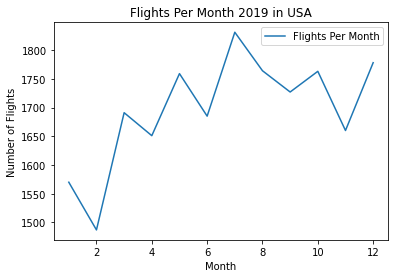

In [ ]:
# Number of Flights Per Month in 2019 sampled Data
ActualFlights = data2019[data2019['Cancelled'] != 1.00 ] #Cancelled=1, means it was cancelled
ActualFlightsMonth = ActualFlights.groupby(by=['Month']).Year.agg('count').to_frame('Flights Per Month')
fig = ActualFlightsMonth.plot()
fig.set_ylabel('Number of Flights')
fig.set_title('Flights Per Month 2019 in USA')

In [ ]:
data2019.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum
0,2019,1,1,1,2,2019-01-01,F9,20436,N308FR,1686,10693,30693,BNA,"Nashville, TN",TN,47,Tennessee,54,13204,31454,MCO,"Orlando, FL",FL,12,Florida,33,1635,1642,7.00,7.00,0.00,0,1600-1659,19.00,1701,1927,9.00,1931,1936,5.00,5.00,0.00,0,1900-1959,0.00,0,0.00,116.00,114.00,86.00,1.00,616.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019,1,1,1,2,2019-01-01,B6,20409,N658JB,1094,10423,30423,AUS,"Austin, TX",TX,48,Texas,74,12478,31703,JFK,"New York, NY",NY,36,New York,22,1351,1551,120.00,120.00,1.00,8,1300-1359,12.00,1603,1958,5.00,1825,2003,98.00,98.00,1.00,6,1800-1859,0.00,0,0.00,214.00,192.00,175.00,1.00,1521.00,7,9.00,0.00,0.00,0.00,89.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019,1,1,1,2,2019-01-01,WN,19393,N7834A,920,13796,32457,OAK,"Oakland, CA",CA,06,California,91,12892,32575,LAX,"Los Angeles, CA",CA,06,California,91,1150,1152,2.00,2.00,0.00,0,1100-1159,37.00,1229,1326,4.00,1320,1330,10.00,10.00,0.00,0,1300-1359,0.00,0,0.00,90.00,98.00,57.00,1.00,337.00,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019,1,1,1,2,2019-01-01,UA,19977,N853UA,400,11292,30325,DEN,"Denver, CO",CO,08,Colorado,82,11057,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,1745,1743,-2.00,0.00,0.00,-1,1700-1759,18.00,1801,2230,9.00,2255,2239,-16.00,0.00,0.00,-2,2200-2259,0.00,0,0.00,190.00,176.00,149.00,1.00,1337.00,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019,1,1,1,2,2019-01-01,AA,19805,N964AN,2306,14679,33570,SAN,"San Diego, CA",CA,06,California,91,12478,31703,JFK,"New York, NY",NY,36,New York,22,2139,2140,1.00,1.00,0.00,0,2100-2159,15.00,2155,0530,4.00,0555,0534,-21.00,0.00,0.00,-2,0001-0559,0.00,0,0.00,316.00,294.00,275.00,1.00,2446.00,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2019,1,1,1,2,2019-01-01,WN,19393,N221WN,1371,13796,32457,OAK,"Oakland, CA",CA,06,California,91,14747,30559,SEA,"Seattle, WA",WA,53,Washington,93,1050,1136,46.00,46.00,1.00,3,1000-1059,10.00,1146,1329,6.00,1300,1335,35.00,35.00,1.00,2,1300-1359,0.00,0,0.00,130.00,119.00,103.00,1.00,672.00,3,0.00,0.00,0.00,0.00,35.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2019,1,1,1,2,2019-01-01,DL,19790,N776DE,1280,14747,30559,SEA,"Seattle, WA",WA,53,Washington,93,10721,30721,BOS,"Boston, MA",MA,25,Massachusetts,13,1100,1106,6.00,6.00,0.00,0,1100-1159,11.00,1117,1847,5.00,1913,1852,-21.00,0.00,0.00,-2,1900-1959,0.00,0,0.00,313.00,286.00,270.00,1.00,2496.00,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2019,1,1,1,2,2019-01-01,WN,19393,N211WN,724,10821,30852,BWI,"Baltimore, MD",MD,24,Maryland,35,13495,33495,MSY,"New Orleans, LA",LA,22,Louisiana,72,0820,0833,13.00,13.00,0.00,0,0800-0859,12.00,0845,1029,3.00,1025,1032,7.00,7.00,0.00,0,1000-1059,0.00,0,0.00,185.00,179.00,164.00,1.00,998.00,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2019,1,1,1,2,2019-01-01,DL,19790,N936AT,1980,13487,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,11433,31295,DTW,"Detroit, MI",MI,26,Michigan,43,1425,1422,-3.00,0.00,0.00,-1,1400-1459,14.00,1436,1644,8.00,1708,1652,-16.00,0.00,0.00,-2,1700-1759,0.00,0,0.00,103.00,90.00,68.00,1.00,528.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2019,1,1,1,2,2019-01-01,WN,19393

In [ ]:
data2019.tail(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum
20356,2019,4,12,31,2,2019-12-31,MQ,20398,N697AB,4241,13244,33244,MEM,"Memphis, TN",TN,47,Tennessee,54,13303,32467,MIA,"Miami, FL",FL,12,Florida,33,1115,1108,-7.00,0.00,0.00,-1,1100-1159,13.00,1121,1418,4.00,1440,1422,-18.00,0.00,0.00,-2,1400-1459,0.00,0,0.00,145.00,134.00,117.00,1.00,859.00,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20357,2019,4,12,31,2,2019-12-31,EV,20366,N609UX,4389,14683,33214,SAT,"San Antonio, TX",TX,48,Texas,74,12266,31453,IAH,"Houston, TX",TX,48,Texas,74,1003,1000,-3.00,0.00,0.00,-1,1000-1059,18.00,1018,1058,11.00,1107,1109,2.00,2.00,0.00,0,1100-1159,0.00,0,0.00,64.00,69.00,40.00,1.00,191.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20358,2019,4,12,31,2,2019-12-31,AA,19805,N956AN,972,11298,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,12094,34699,HDN,"Hayden, CO",CO,08,Colorado,82,1148,1144,-4.00,0.00,0.00,-1,1100-1159,30.00,1214,1317,7.00,1321,1324,3.00,3.00,0.00,0,1300-1359,0.00,0,0.00,153.00,160.00,123.00,1.00,769.00,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20359,2019,4,12,31,2,2019-12-31,WN,19393,N7865A,2147,13204,31454,MCO,"Orlando, FL",FL,12,Florida,33,13495,33495,MSY,"New Orleans, LA",LA,22,Louisiana,72,1020,1016,-4.00,0.00,0.00,-1,1000-1059,15.00,1031,1100,4.00,1110,1104,-6.00,0.00,0.00,-1,1100-1159,0.00,0,0.00,110.00,108.00,89.00,1.00,551.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20360,2019,4,12,31,2,2019-12-31,DL,19790,N540US,1096,14747,30559,SEA,"Seattle, WA",WA,53,Washington,93,12758,32758,KOA,"Kona, HI",HI,15,Hawaii,2,1530,1525,-5.00,0.00,0.00,-1,1500-1559,18.00,1543,1924,3.00,1957,1927,-30.00,0.00,0.00,-2,1900-1959,0.00,0,0.00,387.00,362.00,341.00,1.00,2688.00,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20361,2019,4,12,31,2,2019-12-31,WN,19393,N8529Z,5400,13232,30977,MDW,"Chicago, IL",IL,17,Illinois,41,12889,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,1045,1107,22.00,22.00,1.00,1,1000-1059,17.00,1124,1235,4.00,1245,1239,-6.00,0.00,0.00,-1,1200-1259,0.00,0,0.00,240.00,212.00,191.00,1.00,1521.00,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20362,2019,4,12,31,2,2019-12-31,NK,20416,N690NK,643,11433,31295,DTW,"Detroit, MI",MI,26,Michigan,43,15304,33195,TPA,"Tampa, FL",FL,12,Florida,33,0800,0755,-5.00,0.00,0.00,-1,0800-0859,47.00,0842,1057,9.00,1049,1106,17.00,17.00,1.00,1,1000-1059,0.00,0,0.00,169.00,191.00,135.00,1.00,983.00,4,0.00,0.00,17.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20363,2019,4,12,31,2,2019-12-31,G4,20368,231NV,1242,14082,34082,PGD,"Punta Gorda, FL",FL,12,Florida,33,10431,30431,AVL,"Asheville, NC",NC,37,North Carolina,36,1757,1756,-1.00,0.00,0.00,-1,1700-1759,8.00,1804,1921,7.00,1935,1928,-7.00,0.00,0.00,-1,1900-1959,0.00,0,0.00,98.00,92.00,77.00,1.00,588.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20364,2019,4,12,31,2,2019-12-31,NK,20416,N695NK,779,12953,31703,LGA,"New York, NY",NY,36,New York,22,11697,32467,FLL,"Fort Lauderdale, FL",FL,12,Florida,33,2020,2132,72.00,72.00,1.00,4,2000-2059,12.00,2144,0010,7.00,2329,0017,48.00,48.00,1.00,3,2300-2359,0.00,0,0.00,189.00,165.00,146.00,1.00,1076.00,5,4.00,0.00,1.00,0.00,43.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
203

In [ ]:
data2019.dtypes  # Create table to see all

Year                 int64
Quarter              int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
                     ...  
Div1WheelsOn        object
Div1TotalGTime      object
Div1LongestGTime    object
Div1WheelsOff       object
Div1TailNum         object
Length: 73, dtype: object

In [ ]:
data2019.isnull().sum() #Create table to see all and percentages. 

Year                0
Quarter             0
Month               0
DayofMonth          0
DayOfWeek           0
                   ..
Div1WheelsOn        0
Div1TotalGTime      0
Div1LongestGTime    0
Div1WheelsOff       0
Div1TailNum         0
Length: 73, dtype: int64

In [ ]:
# CLEANING THE 2019 dataframe

# NULL → 0
data2019 = data2019.fillna(0)

# NAN → 0
data2019 = data2019.replace('NAN', '0')

# NA → 0
data2019 = data2019.replace('NA', '0')

# $- → 0
data2019 = data2019.replace(' $-   ', '0')

In [ ]:
# correcting data types of columns that are int or float
# but currently are established as type object, because they 
# couldn't be read originally as int or float because of NULLs 
# and NANS present in their rows

'''
head 1000 rows
datatype correction
numericColumns = data2019.columns.drop(['string columns'])
data2019[conumericColumnsls] = data2019[numericColumns].apply(pd.to_numeric, errors='coerce')
'''

df1raw.round(2)
data2019

In [ ]:
data2019.dtypes

In [ ]:
data2019.describe()

**Understanding 2020-early2021**

In [ ]:
# CLEANING THE 2019 dataframe

# NULL → 0
data2020_2021 = data2020_2021.fillna(0)

# NAN → 0
data2020_2021 = data2020_2021.replace('NAN', '0')

# NA → 0
data2019 = data2019.replace('NA', '0')

# $- → 0
data2020_2021 = data2020_2021.replace(' $-   ', '0')

In [ ]:
data2018_2019['FlightDate'] = pd.to_datetime(data2018_2019['FlightDate'])

In [ ]:
data2018_2019.sort_values(by=['FlightDate'], inplace=True)

KeyboardInterrupt: ignored

In [ ]:
data2018_2019.info()

In [ ]:
data2018_2019.head(30)

In [ ]:
data2018_2019.tail(30)

In [ ]:
data2018_2019.size

NameError: ignored

In [ ]:
data2018_2019.describe()

**Storing the data of this notebook as a single csv 2019-Early2021**

In [ ]:
frames = [data2019, data2020_2021]
data2019_early2021 = pd.concat(frames)

**Understanding 2020**


In [ ]:
# RENAME ALL COLUMNS!! using IBM Naming 

In [ ]:
data2020_2021['Year'].unique()

In [ ]:
data2020_2021.tail()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,...,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM,Unnamed: 109
38524,2020,3,9,5,6,2020-09-05,OO,20304,OO,N187PQ,3789,13433,1343302,33304,MOT,"Minot, ND",ND,38,North Dakota,66,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,800,756.0,-4.0,0.0,0.0,-1.0,0800-0859,10.0,806.0,907.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38525,2020,3,9,5,6,2020-09-05,OO,20304,OO,N429SW,3790,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,11612,1161206,31612,EVV,"Evansville, IN",IN,18,Indiana,42,2120,2113.0,-7.0,0.0,0.0,-1.0,2100-2159,14.0,2127.0,2125.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38526,2020,3,9,5,6,2020-09-05,OO,20304,OO,N838SK,3791,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,13851,1385103,33851,OKC,"Oklahoma City, OK",OK,40,Oklahoma,73,1745,1742.0,-3.0,0.0,0.0,-1.0,1700-1759,13.0,1755.0,1921.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38527,2020,3,9,5,6,2020-09-05,OO,20304,OO,N429SW,3792,12884,1288403,32884,LAN,"Lansing, MI",MI,26,Michigan,43,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,630,625.0,-5.0,0.0,0.0,-1.0,0600-0659,8.0,633.0,652.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38528,2020,3,9,5,6,2020-09-05,OO,20304,OO,N296SY,3793,11638,1163807,31638,FAT,"Fresno, CA",CA,6,California,91,14869,1486903,34614,SLC,"Salt Lake City, UT",UT,49,Utah,87,623,913.0,170.0,170.0,1.0,11.0,0600-0659,9.0,922.0,1136.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data2020_2021.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 110 entries, YEAR to Unnamed: 109
dtypes: object(19), float64(70), int64(21)

In [ ]:
import random
NSAMPLES = 1000000
sampled_indices = random.sample(range(len(datdata_toSamplea)), NSAMPLES )
dataSampled = data[data.index in sampled_indices]

In [ ]:
df.to_csv('sample.csv', dtype= typesDict)

In [ ]:
data = pd.read_csv('we4.csv', dtype = typesDict)[col_list]
data.info()

In [ ]:
data['Year'].count()

In [ ]:
df.head()

**1987-2021**

This was just done for helping the community to have a more updated dataset of the Airline ON TIME performance data

In [ ]:
# 1,000,000 Rows Sample for some general questions

**2018-2021 DATASET**

This is the real dataset we'll be analysing

In [ ]:
# Filter the data into different data frames per year. To speed up save to a csv each dataframe

## **Exploratory Data Analysis (EDA)**

Let's Remember that the 2018 - March 2021 Dataset is the dataset that will help to solve the Lead Question.

Proceso 
* See the head and tail
* See the statistics
* See each column data type and count()
* Shape of the data frame
* Null Percentages
* Profile Report
* Look for columns that are ids, numerical, categories
* Several Tables? Understand their Relation
* Conclusion

In [ ]:
# Check Number of Partitions
df

In [ ]:
# First 5 Rows - Just for a quick exploration
df.head()

In [ ]:
# Last 5 Rows - Just for a quick exploration
df.tail()

In [ ]:
# There should be around 194,385,636 fligths (rows)
value = df['Year'].count().compute()
print("El tamaño del dataset es: ", f'{value:,}')

In [ ]:
# Get the Basic Statistics 
print("Info del dataset: ", df.describe().compute()) 

In [ ]:
 df.describe()

In [ ]:
# Null Percentage per column
total_of_all = df.isnull().sum()
percent_of_all = (df.isnull().sum()/df.isnull().count())
missing_data_test = dd.concat([total_of_all, percent_of_all*100], axis=1, keys=['Total Nulos', 'Percent'])
missing_data_test.head(29)

### DATA CLEANING

Proceso
* Get dataset related dictionaries
* Rename with descriptive column names.
* Correct format and data types of each column
* DML Missing data that doesn't affect the leading Q
* Llenar Nulls con 0, solo si hace sentido
* Eliminar columnas que no apoyen la(s) pregunta(s)
* Muy grande? Haz un sample en .csv para trabajarlo
* Datos muy desproporcionados, rescálalos.

In [ ]:
# First 1000 Rows - Use them to explore the dataset columns and to correct types dictionary
df.head(1000).to_csv('Head_Airlines.csv') 

In [ ]:
# Last 1000 Rows - Use them to explore the dataset columns and to correct types dictionary
df.tail(1000).to_csv('Tail_Airlines.csv') 

In [ ]:
# Delete columns with 70 to 100% nulls

In [ ]:
# Give descriptive name with the column name dictionary

In [ ]:
# Get a sample to work with
df = df.compute()                          # dask DataFrame to pandas
df.sample(sample=500, random_state = 1000) # Use 'frac' instead of 'sample' with dask DataFrame, 
                                           # add a seed like'random_state = 1000' to ensure that resuls can be recreated

In [ ]:
# Load related dictionaries - suggested geo json, Airlines Code To Name and IATA code to name

In [ ]:
# Explore each dictionary (head, dtypes, columns, describe)

### DATA VISUALIZATION

Proceso
* Functions for quick grouping of data for visualization
* Maps: Choropleth, Geolocation, etc.
* One Variable Charts
* Two Variable Charts
* Three or more Variable Charts
* Diagrams

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# Plot Test
plt.hist(x=df['Cancelled'], bins='auto')
plt.xlabel('Cancelled')
plt.ylabel('Frequency')

In [ ]:
# Decide the Plots

In [ ]:
# Plot Destiny Airports Density (per year or through a year GIF)

In [ ]:
# Plot Origin Airports Density (per year or through a year GIF)

In [ ]:
# Plot Airport FLight Path (per year or through a year GIF)

In [ ]:
# Choropleth Map of USA (per year or through a year GIF)

In [ ]:
# Flight Frequency Diagram (per year or through a year)

In [ ]:
# Flight Pattern of Mexican Airlines in the USA (GIF)

### Warming Up Questions

In [ ]:
# Name of the Oldest Flying Plane

In [ ]:
# Airlines with the newest and oldest planes

In [ ]:
# Airline with the most flights per year

In [ ]:
# Average delay time per airline

In [ ]:
# Day of the week with the least delay time

In [ ]:
# Cities with above average weather delay time

In [ ]:
# Airports with above average Taxi IN/Out delay time

In [ ]:
# Most flown cities and the cause most common cause of delays in their airpots

In [ ]:
# How does weather delay time relate to a Flight being cancelled?

In [ ]:
# Actual arrival time minus scheduled arrival time vs Actual departure time minus scheduled arrival time 

### Covid related questions, but not the lead question

In [ ]:
# Is there an airline with decreasing flights per year? (Before Covid)

In [ ]:
# How delay time behaved during covid () ?

In [ ]:
# How the Top 5 and Bottom 5 Airlines behaved during covid

In [ ]:
# Did flight patterns change?

In [ ]:
# Warming Up Questions but just in covid period

In [ ]:
# Did the most common diverted airport go to changed after covid?

In [ ]:
# How diverted attributes changed during covid?

### Aviation: Predict which flights are likely to arrive on time

### Cluster Ideas

In [ ]:
# What would be some interesting clusters

## **LEAD QUESTION'S ANSWER**

# **Publishing in Kaggle**